<a href="https://colab.research.google.com/github/divya-r-kamat/NLP-With-PyTorch/blob/master/BERT/SpamClassification/Spam_Classification_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spam Classification using BERT

Google Colab offers free GPUs and TPUs! Since we'll be training a large neural network it's best to take advantage of this (in this case we'll attach a GPU), otherwise training will take a very long time.

A GPU can be added by going to the menu and selecting:

Edit 🡒 Notebook Settings 🡒 Hardware accelerator 🡒 (GPU)

Then run the following cell to confirm that the GPU is detected.

In [1]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In order for torch to use the GPU, we need to identify and specify the GPU as the device. Later, in our training loop, we will load data onto the device.

In [2]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


## Installing the Hugging Face Library

Next, let's install the transformers package from Hugging Face which will give us a pytorch interface for working with BERT. (This library contains interfaces for other pretrained language models like OpenAI's GPT and GPT-2.) 
The library also includes task-specific classes for token classification, question answering, next sentence prediciton, etc. Using these pre-built classes simplifies the process of modifying BERT for your purposes.

In [3]:
!pip install transformers

     |████████████████████████████████| 2.2MB 19.6MB/s 
     |████████████████████████████████| 870kB 53.6MB/s 
     |████████████████████████████████| 3.3MB 56.3MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.44-cp37-none-any.whl size=886084 sha256=bd050782b03f5f9b9e4ff9ce590e0bd288b06d490a35a3482a9dbae88749e1c6
  Stored in directory: /root/.cache/pip/wheels/3e/fb/c0/13ab4d63d537658f448366744654323077c4d90069b6512f3c
Successfully built sacremoses


## Import Libraries

In [4]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from torchtext.legacy.data import Field, TabularDataset, BucketIterator, Iterator
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import torch.nn as nn
import time
import math

## Load Dataset

In [5]:
df = pd.read_csv("/content/drive/MyDrive/BERT/Spam_Classification/spamdata_v2.csv")

# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(df.shape[0]))

# Display 10 random rows from the data.
df.sample(10)

Number of training sentences: 5,572



,label,text
4142,1,In The Simpsons Movie released in July 2007 na...
167,0,"Hi frnd, which is best way to avoid missunders..."
5209,0,"I know you are thinkin malaria. But relax, chi..."
2412,1,I don't know u and u don't know me. Send CHAT ...
4787,0,Thanx. Yup we coming back on sun. Finish dinne...
3377,0,Hows that watch resizing
3785,0,Wat r u doing?
1063,1,We have new local dates in your area - Lots of...
3622,0,"Damn, poor zac doesn't stand a chance"
2229,0,haha but no money leh... Later got to go for t...


In [6]:
# check class distribution
df['label'].value_counts(normalize = True)

0    0.865937
1    0.134063
Name: label, dtype: float64

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


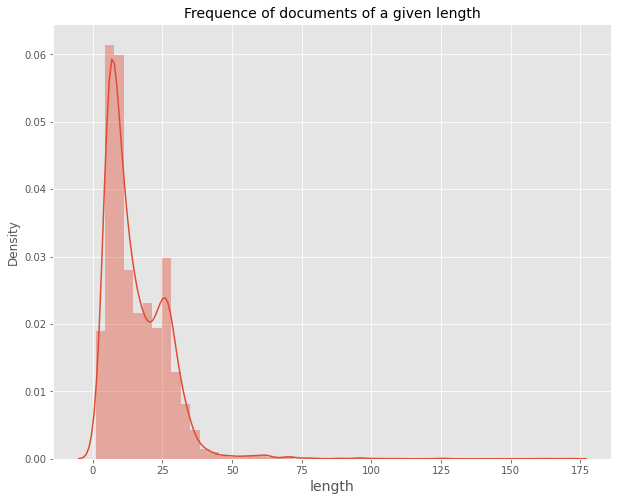

In [7]:

# Plot histogram with the length. Truncate max length to 5000 tokens.
plt.style.use("ggplot")

plt.figure(figsize=(10, 8))
df['length'] = df['text'].apply(lambda x: len(x.split()))
sns.distplot(df[df['length'] < 5000]['length'])
plt.title('Frequence of documents of a given length', fontsize=14)
plt.xlabel('length', fontsize=14)
None

## Tokenization & Input Formatting
In this  we'll transform our dataset into the format that BERT can be trained on.

To feed our text to BERT, it must be split into tokens, and then these tokens must be mapped to their index in the tokenizer vocabulary.

The tokenization must be performed by the tokenizer included with BERT--the below cell will download this for us. We'll be using the "uncased" version here.

In [8]:
from transformers import BertTokenizer,AutoModel, AdamW, get_linear_schedule_with_warmup

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


Let's apply the tokenizer to one sentence just to see the output.

In [9]:
# Print the original sentence.
print(' Original: ', df['text'][0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(df['text'][0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(df['text'][0])))

 Original:  Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
Tokenized:  ['go', 'until', 'ju', '##rong', 'point', ',', 'crazy', '.', '.', 'available', 'only', 'in', 'bug', '##is', 'n', 'great', 'world', 'la', 'e', 'buffet', '.', '.', '.', 'ci', '##ne', 'there', 'got', 'amore', 'wat', '.', '.', '.']
Token IDs:  [2175, 2127, 18414, 17583, 2391, 1010, 4689, 1012, 1012, 2800, 2069, 1999, 11829, 2483, 1050, 2307, 2088, 2474, 1041, 28305, 1012, 1012, 1012, 25022, 2638, 2045, 2288, 26297, 28194, 1012, 1012, 1012]


In [10]:
# Get the lists of text and their labels.
sentences = df.text.values
labels = df.label.values

In [11]:
max_len = 0

# For every sentence...
for sent in sentences:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Max sentence length:  238


In [12]:
# Set tokenizer hyperparameters.
MAX_SEQ_LEN = 230
BATCH_SIZE = 16
PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)



# Define columns to read.
label_field = Field(sequential=False, use_vocab=False, batch_first=True)
text_field = Field(use_vocab=False, 
                   tokenize=tokenizer.encode, 
                   include_lengths=False, 
                   batch_first=True,
                   fix_length=MAX_SEQ_LEN, 
                   pad_token=PAD_INDEX, 
                   unk_token=UNK_INDEX)


fields = {'text' : ('text', text_field), 'label' : ('label', label_field)}


# Read preprocessed CSV into TabularDataset and split it into train, test and valid.
train_data, valid_data, test_data = TabularDataset(path="/content/drive/MyDrive/BERT/Spam_Classification/spamdata_v2.csv", 
                                                   format='CSV', 
                                                   fields=fields, 
                                                   skip_header=False).split(split_ratio=[0.70, 0.2, 0.1], 
                                                                            stratified=True, 
                                                                            strata_field='label')
                                                   
# Create train and validation iterators.
train_iter, valid_iter = BucketIterator.splits((train_data, valid_data),
                                               batch_size=BATCH_SIZE,
                                               device=device,
                                               shuffle=True,
                                               sort_key=lambda x: len(x.text), 
                                               sort=True, 
                                               sort_within_batch=False)


# Test iterator, no shuffling or sorting required.
test_iter = Iterator(test_data, batch_size=BATCH_SIZE, device=device, train=False, shuffle=False, sort=False)

In [13]:
for i in train_iter:
  print(i.text)
  break

tensor([[ 101, 7929,  102,  ...,    0,    0,    0],
        [ 101, 7929,  102,  ...,    0,    0,    0],
        [ 101, 7929,  102,  ...,    0,    0,    0],
        ...,
        [ 101, 9805, 2361,  ...,    0,    0,    0],
        [ 101, 7929, 1012,  ...,    0,    0,    0],
        [ 101, 7929, 1012,  ...,    0,    0,    0]], device='cuda:0')


In [14]:
class BERT_Arch(nn.Module):

    def __init__(self):
      
      super(BERT_Arch, self).__init__()

      self.bert = AutoModel.from_pretrained('bert-base-uncased',return_dict=False) 
      
      # dropout layer
      self.dropout = nn.Dropout(0.1)
      
      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)
      
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,2)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      _, cls_hs = self.bert(sent_id, mask)
      
      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)
      
      # apply softmax activation
      x = self.softmax(x)

      return x

In [15]:
# Functions for saving and loading model parameters and metrics.
def save_checkpoint(path, model, valid_loss):
    torch.save({'model_state_dict': model.state_dict(),
                  'valid_loss': valid_loss}, path)

    
def load_checkpoint(path, model):    
    state_dict = torch.load(path, map_location=device)
    model.load_state_dict(state_dict['model_state_dict'])
    
    return state_dict['valid_loss']


def save_metrics(path, train_loss_list, valid_loss_list):   
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list }
    
    torch.save(state_dict, path)


def load_metrics(path):    
    state_dict = torch.load(path, map_location=device)
    return state_dict['train_loss_list'], state_dict['valid_loss_list']

In [16]:

def train(model, iterator, optimizer, criterion, clip,scheduler = None):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src = batch.text
        trg = batch.label
        mask = (src != PAD_INDEX).type(torch.uint8)
        
        optimizer.zero_grad()

        output = model(src, mask)
            
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        scheduler.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [17]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.text
            trg = batch.label
            mask = (src != PAD_INDEX).type(torch.uint8)

            output = model(src, mask)
            
            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [19]:
output_path='/content'

In [20]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [21]:
steps_per_epoch = len(train_iter)
CLIP = 1
criterion = nn.CrossEntropyLoss()

model = BERT_Arch()
model = model.to(device)

In [22]:
# # Main training loop
# NUM_EPOCHS = 6

# optimizer = AdamW(model.parameters(), lr=1e-4)
# scheduler = get_linear_schedule_with_warmup(optimizer, 
#                                             num_warmup_steps=steps_per_epoch*1, 
#                                             num_training_steps=steps_per_epoch*NUM_EPOCHS)

# print("======================= Start Pre-training =================================")

# # Pretrain linear layers, do not train bert
# for param in model.bert.parameters():
#   param.requires_grad = False
# for epoch in range(NUM_EPOCHS):

#     start_time = time.time()
    
#     train_loss = train(model, train_iter, optimizer, criterion, CLIP,scheduler=scheduler)
#     valid_loss = evaluate(model, valid_iter, criterion)
    
#     end_time = time.time()
    
#     epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
#     # if valid_loss < best_valid_loss:
#     #     best_valid_loss = valid_loss
#     #     save_checkpoint(output_path + '/model.pkl', model, best_valid_loss)
#     #     save_metrics(output_path + '/metric.pkl', train_loss_list, valid_loss_list)
    
#     print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
#     print(f'\tTrain Loss: {train_loss:.3f}')
#     print(f'\t Val. Loss: {valid_loss:.3f}')


# # Pretrain linear layers, do not train bert
# for param in model.bert.parameters():
#   param.requires_grad = True

# print('Pre-training done!')

======================= Start Pre-training =================================
Epoch: 01 | Time: 1m 5s
	Train Loss: 0.012
	 Val. Loss: 0.000
Epoch: 02 | Time: 1m 9s
	Train Loss: 0.000
	 Val. Loss: 0.000
Epoch: 03 | Time: 1m 11s
	Train Loss: 0.000
	 Val. Loss: 0.000
Epoch: 04 | Time: 1m 14s
	Train Loss: 0.000
	 Val. Loss: 0.000
Epoch: 05 | Time: 1m 15s
	Train Loss: 0.000
	 Val. Loss: 0.000
Epoch: 06 | Time: 1m 14s
	Train Loss: 0.000
	 Val. Loss: 0.000
Pre-training done!


In [22]:
# Main training loop

N_EPOCHS = 10

best_valid_loss = float('inf')

print("======================= Start training =================================")
optimizer = AdamW(model.parameters(), lr=2e-6)
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=steps_per_epoch*2, 
                                            num_training_steps=steps_per_epoch*N_EPOCHS)

train_loss_list = []
valid_loss_list=[]

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss = train(model, train_iter, optimizer, criterion, CLIP,scheduler=scheduler)
    valid_loss = evaluate(model, valid_iter, criterion)
    train_loss_list.append(train_loss)
    valid_loss_list.append(valid_loss)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        save_checkpoint(output_path + '/model.pkl', model, best_valid_loss)
        save_metrics(output_path + '/metric.pkl', train_loss_list, valid_loss_list)
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f}')

print('Training done!')

======================= Start training =================================
Epoch: 01 | Time: 2m 41s
	Train Loss: 0.613
	 Val. Loss: 0.522
Epoch: 02 | Time: 2m 51s
	Train Loss: 0.307
	 Val. Loss: 0.141
Epoch: 03 | Time: 2m 52s
	Train Loss: 0.085
	 Val. Loss: 0.081
Epoch: 04 | Time: 2m 53s
	Train Loss: 0.045
	 Val. Loss: 0.073
Epoch: 05 | Time: 2m 53s
	Train Loss: 0.035
	 Val. Loss: 0.071
Epoch: 06 | Time: 2m 53s
	Train Loss: 0.030
	 Val. Loss: 0.071
Epoch: 07 | Time: 2m 53s
	Train Loss: 0.025
	 Val. Loss: 0.071
Epoch: 08 | Time: 2m 53s
	Train Loss: 0.022
	 Val. Loss: 0.073
Epoch: 09 | Time: 2m 53s
	Train Loss: 0.021
	 Val. Loss: 0.073
Epoch: 10 | Time: 2m 53s
	Train Loss: 0.020
	 Val. Loss: 0.074
Training done!


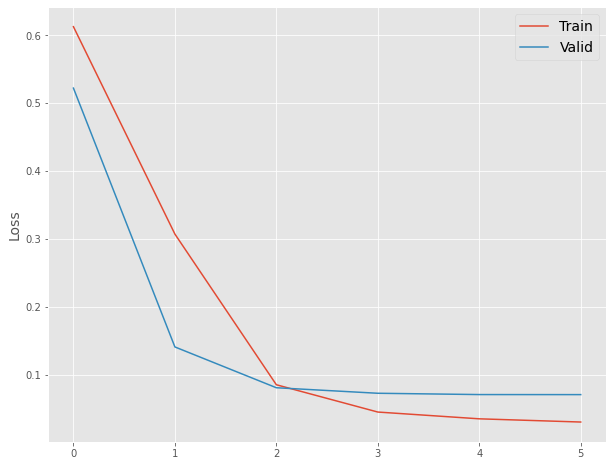

In [23]:
plt.figure(figsize=(10, 8))
train_loss_list, valid_loss_list = load_metrics(output_path + '/metric.pkl')
plt.plot( train_loss_list, label='Train')
plt.plot( valid_loss_list, label='Valid')
# plt.xlabel('Global Steps', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=14)
plt.show()

In [24]:
# Evaluation Function

def evaluate(model, test_loader):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for (source, target), _ in test_loader:
                mask = (source != PAD_INDEX).type(torch.uint8)
                
                output = model(source, mask)

                y_pred.extend(torch.argmax(output, axis=-1).tolist())
                y_true.extend(target.tolist())
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=[1,0], digits=4))
    
    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax = plt.subplot()

    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['SPAM', 'HAM'])
    ax.yaxis.set_ticklabels(['SPAM', 'HAM'])

Classification Report:
              precision    recall  f1-score   support

           1     0.9733    0.9799    0.9766       149
           0     0.9969    0.9959    0.9964       965

    accuracy                         0.9937      1114
   macro avg     0.9851    0.9879    0.9865      1114
weighted avg     0.9937    0.9937    0.9937      1114



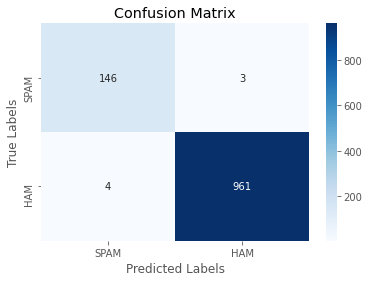

In [25]:
model = BERT_Arch()
model = model.to(device)

load_checkpoint(output_path + '/model.pkl', model)

evaluate(model, test_iter)